In [2]:
import sys
sys.path.append('../../../../src/scVI/')
import scvi
from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.models import VAE, SCANVI
from scvi.dataset.anndataset import AnnDatasetFromAnnData

scvi.__version__ 

[2020-01-23 18:30:08,261] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/angela/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


'0.5.0'

In [3]:
import sys
sys.path.append('../10_utils/')
import colorDict

age_color_dict = colorDict.age_color_dict()
tissue_color_dict = colorDict.tissue_color_dict()

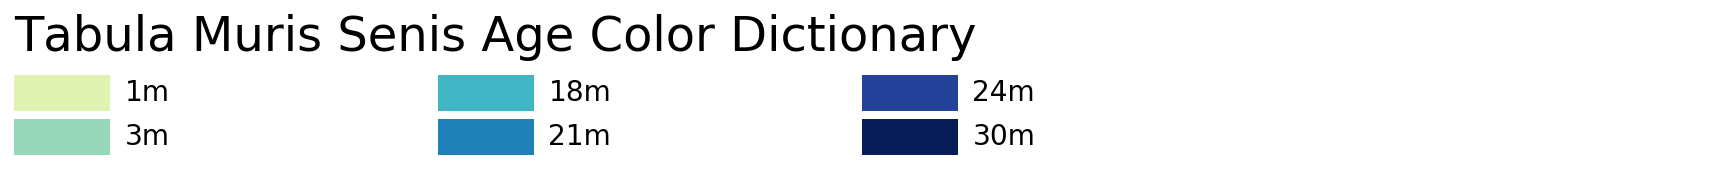

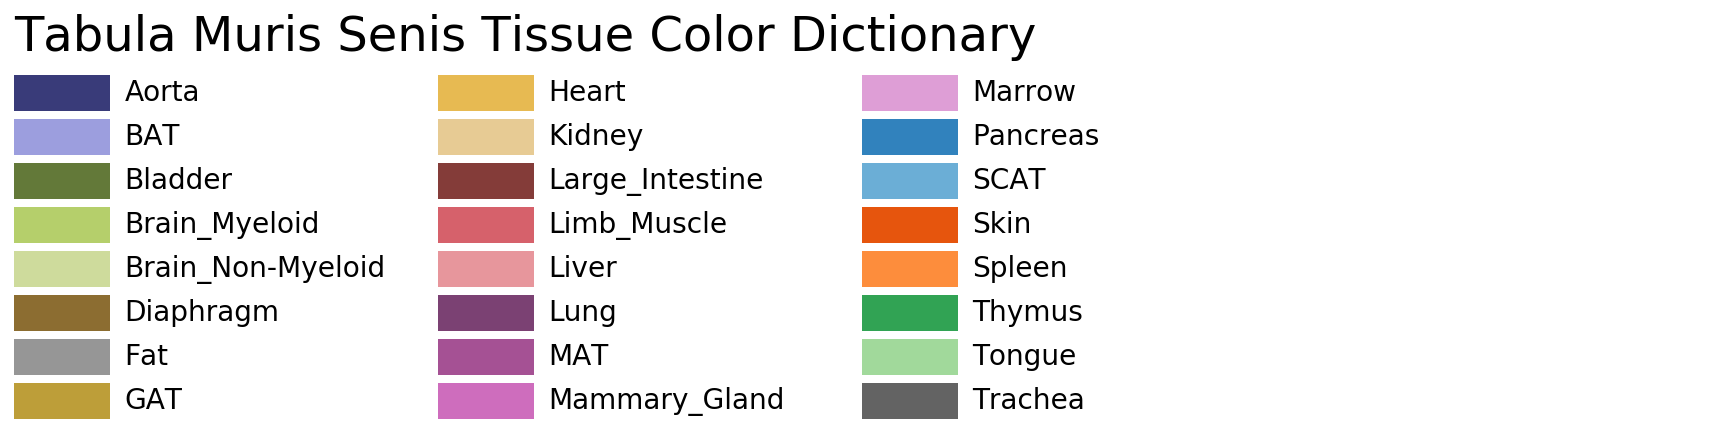

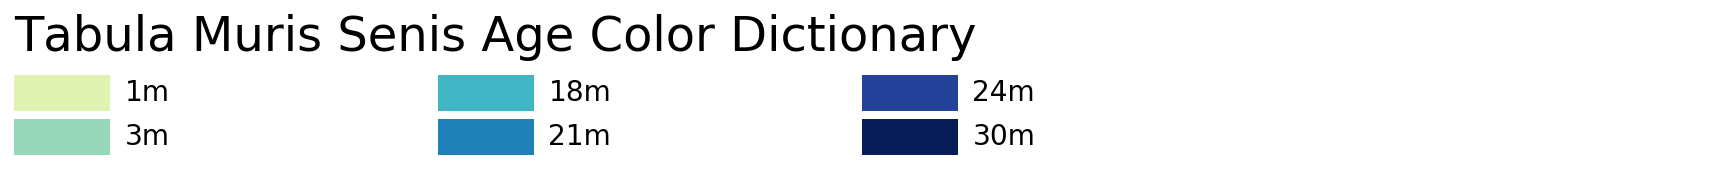

In [20]:
colorDict.plot_colortable(tissue_color_dict, "Tabula Muris Senis Tissue Color Dictionary", sort_colors=False, emptycols=1)
colorDict.plot_colortable(age_color_dict, "Tabula Muris Senis Age Color Dictionary", sort_colors=False, emptycols=1)

In [7]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import csv
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv

sc.settings.verbosity = 3
sc.logging.print_versions()
np.random.seed(685)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize']=(10,10) #rescale figures
sc.settings.set_figure_params(dpi=100)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [7]:
adata = sc.read_h5ad('tms-scVI-adata-with-umaps.h5ad')
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'louvain', 'neighbors', 'pca', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox', 'tissue_colors'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'

In [41]:
adata.obs['tissue_combined'] = adata.obs['tissue'].copy()
adata.obs['tissue_combined'] = adata.obs['tissue_combined'].astype(str)
adata.obs.loc[adata.obs['tissue_combined']=='Heart_and_Aorta','tissue_combined'] = 'Heart'
adata.uns['tissue_combined_colors'] = list(tissue_color_dict.values())
set(adata.obs['tissue_combined'])

{'Aorta',
 'BAT',
 'Bladder',
 'Brain_Myeloid',
 'Brain_Non-Myeloid',
 'Diaphragm',
 'Fat',
 'GAT',
 'Heart',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'MAT',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'SCAT',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

In [54]:
adata.obs['age'] = adata.obs['age'].copy()
adata.uns['age_colors'] = list(age_color_dict.values())


In [52]:
set(adata.obs['age'])

{'18m', '1m', '21m', '24m', '30m', '3m'}

In [53]:
age_color_dict.values()

dict_values(['#e1f3b2', '#97d6b9', '#40b5c4', '#1f80b8', '#24419a', '#081d58'])

In [40]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group', 'tissue_combined'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'louvain', 'neighbors', 'pca', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox', 'tissue_colors', 'method_colors', 'age_colors', 'tissue_combined_colors'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'

In [32]:
adata.uns['tissue_combined_colors']

['#393b79',
 '#9c9ede',
 '#637939',
 '#b5cf6b',
 '#cedb9c',
 '#8c6d31',
 '#969696',
 '#bd9e39',
 '#e7ba52',
 '#e7cb94',
 '#843c39',
 '#d6616b',
 '#e7969c',
 '#7b4173',
 '#a55194',
 '#ce6dbd',
 '#de9ed6',
 '#3182bd',
 '#6baed6',
 '#e6550d',
 '#fd8d3c',
 '#31a354',
 '#a1d99b',
 '#636363']

In [33]:
tissue_color_dict

{'Aorta': '#393b79',
 'BAT': '#9c9ede',
 'Bladder': '#637939',
 'Brain_Myeloid': '#b5cf6b',
 'Brain_Non-Myeloid': '#cedb9c',
 'Diaphragm': '#8c6d31',
 'Fat': '#969696',
 'GAT': '#bd9e39',
 'Heart': '#e7ba52',
 'Kidney': '#e7cb94',
 'Large_Intestine': '#843c39',
 'Limb_Muscle': '#d6616b',
 'Liver': '#e7969c',
 'Lung': '#7b4173',
 'MAT': '#a55194',
 'Mammary_Gland': '#ce6dbd',
 'Marrow': '#de9ed6',
 'Pancreas': '#3182bd',
 'SCAT': '#6baed6',
 'Skin': '#e6550d',
 'Spleen': '#fd8d3c',
 'Thymus': '#31a354',
 'Tongue': '#a1d99b',
 'Trachea': '#636363'}

saving figure to file ./figures/umap_scvi_tissue.pdf


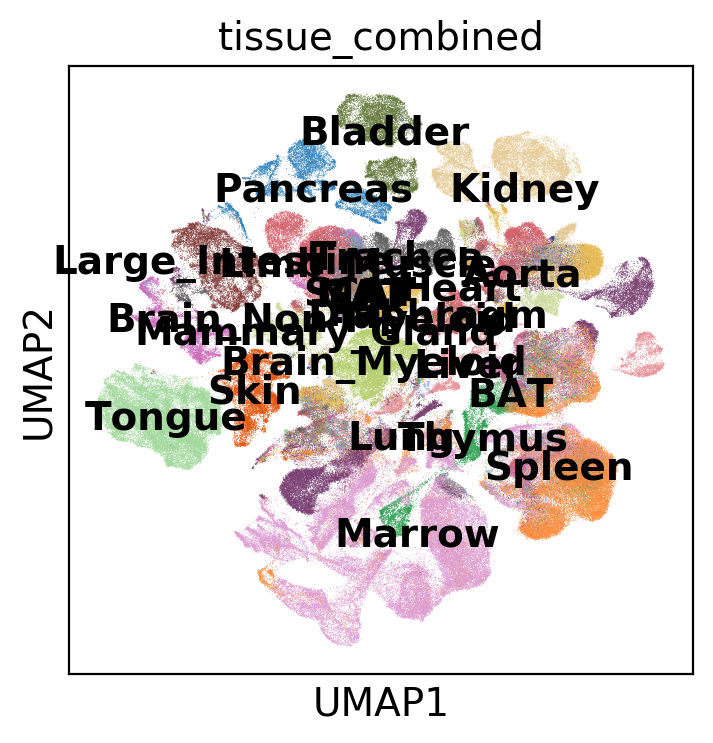

saving figure to file ./figures/umap_scvi_method.pdf


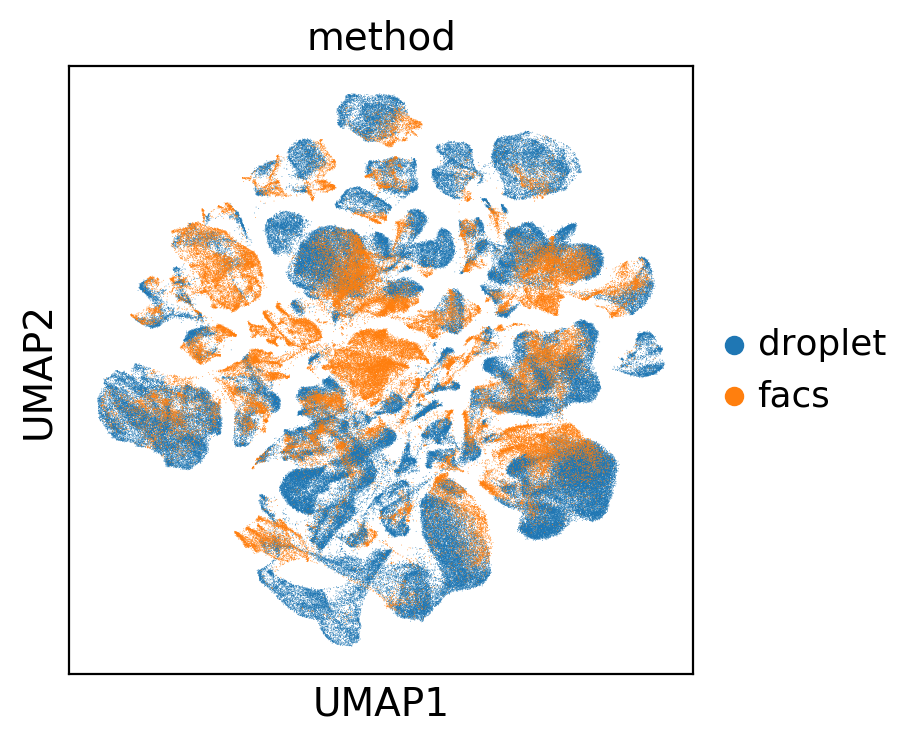

saving figure to file ./figures/umap_scvi_age.pdf


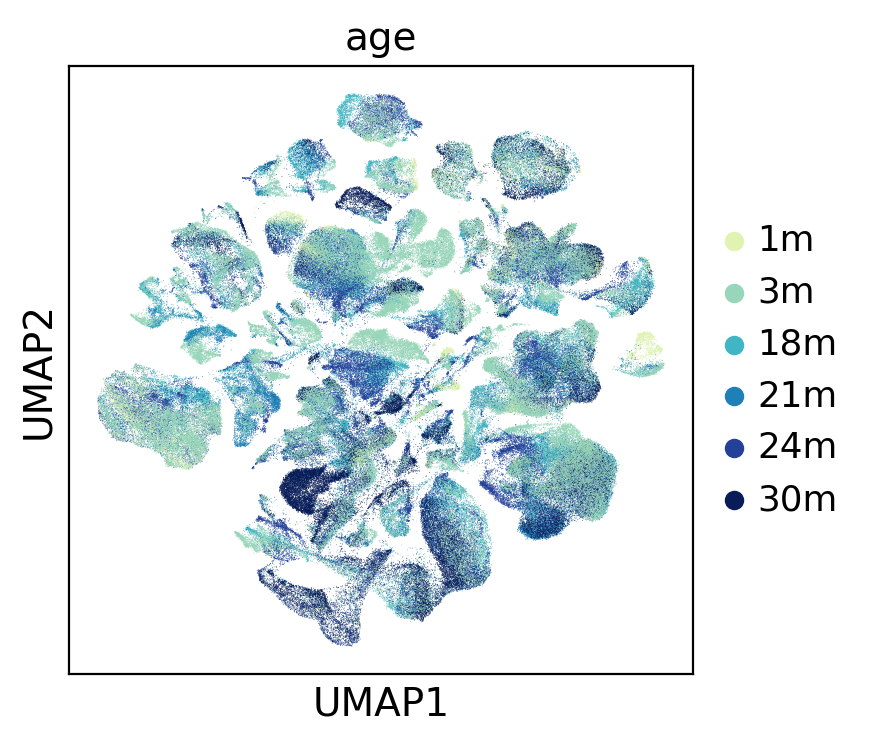

In [58]:
sc.pl.umap(adata,color=['tissue_combined'],legend_loc='on data',save='_scvi_tissue.pdf')
sc.pl.umap(adata,color=['method'],save='_scvi_method.pdf')
sc.pl.umap(adata,color=['age'],save='_scvi_age.pdf')

In [48]:
pwd

'/home/angela/maca/tabula-muris-senis/1_tabula_muris_senis/11_figure_1'

In [8]:
adata = read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-droplet-processed-official-annotations-Liver.h5ad')
adata

AnnData object with n_obs × n_vars = 7294 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

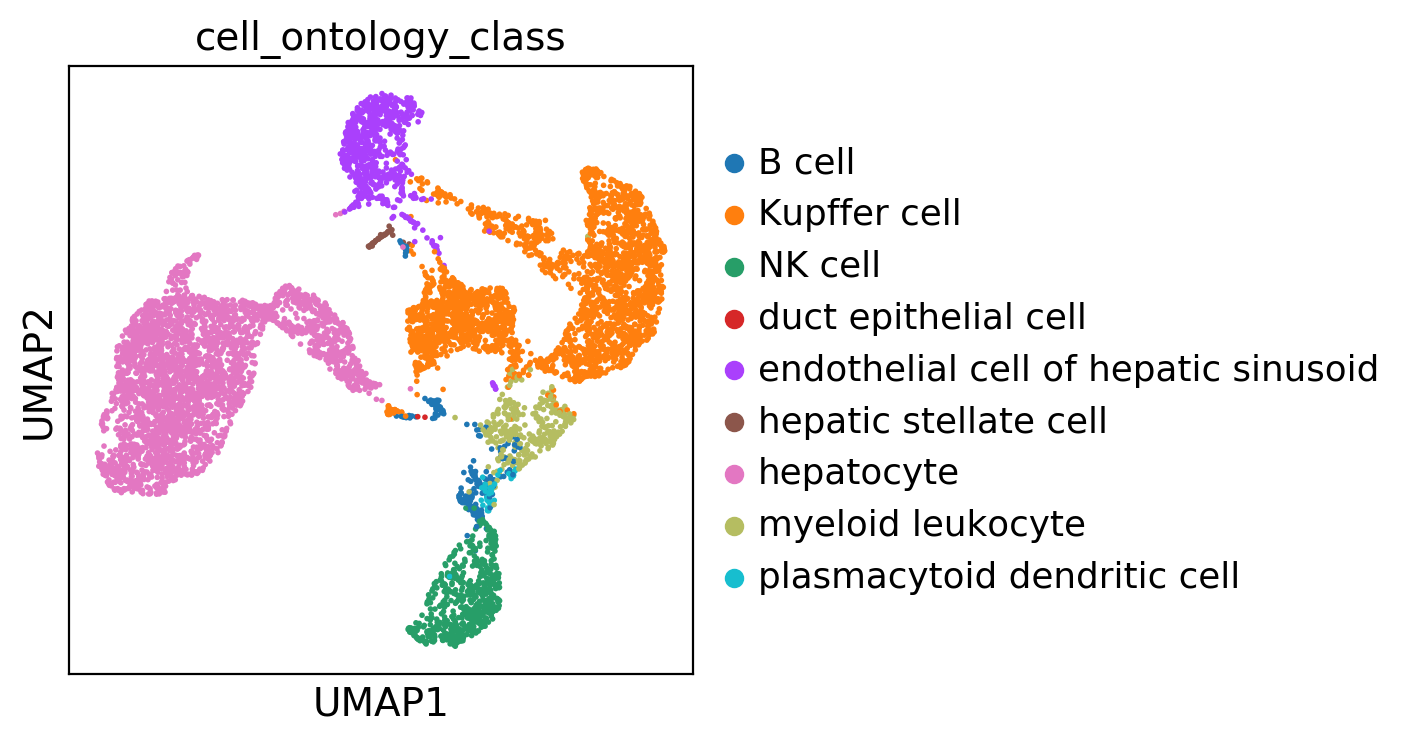

In [9]:
sc.pl.umap(adata,color=['cell_ontology_class'])

In [10]:
adata[adata.obs['cell_ontology_class']=='duct epithelial cell']

View of AnnData object with n_obs × n_vars = 2 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

Liver


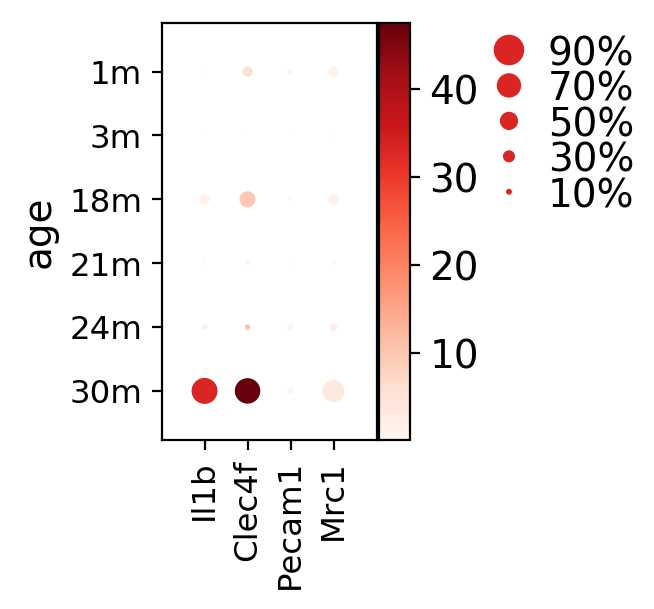

endothelial cell of hepatic sinusoid


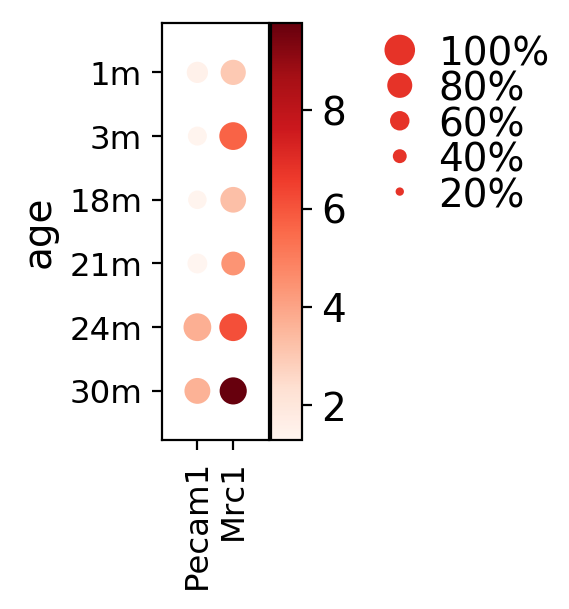

Kupffer cell


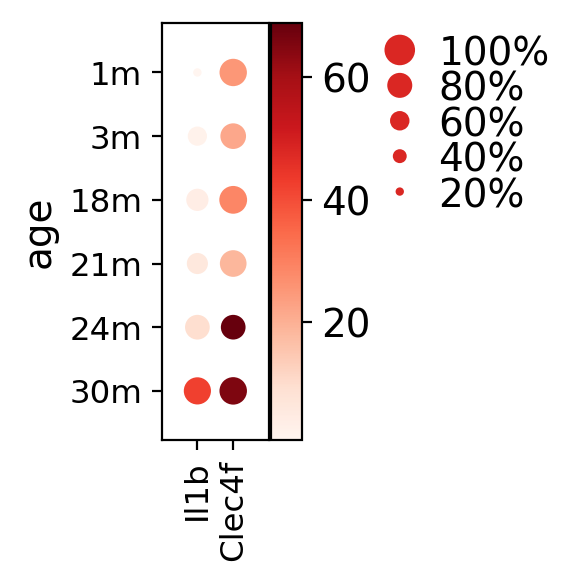

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.7, 0, 0.2, 0.5, 0.25])

In [12]:
print('Liver')
sc.pl.dotplot(adata,['Il1b','Clec4f','Pecam1','Mrc1'],groupby='age')
print('endothelial cell of hepatic sinusoid')
sc.pl.dotplot(adata[adata.obs['cell_ontology_class']=='endothelial cell of hepatic sinusoid'],
              ['Pecam1','Mrc1'],groupby='age', save = '_pecam1_mrc1.pdf')
print('Kupffer cell')
sc.pl.dotplot(adata[adata.obs['cell_ontology_class']=='Kupffer cell'],
              ['Il1b','Clec4f'],groupby='age', save = '_il1b_clec4f.pdf')

# for c in ['endothelial cell of hepatic sinusoid','Kupffer cell']:#list(set(adata.obs['cell_ontology_class'])):
#     print(c)
#     sc.pl.dotplot(adata[adata.obs['cell_ontology_class']==c],['Mrc1','Clec4f','Pecam1','Mrc1'],groupby='age')

In [ ]:
# adata = read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-scVI-official-annotations-umap.h5ad')
adata = read_h5ad('../../../tabula-muris-senis-scVI-official-annotations.h5ad')
adata

In [ ]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_overview(adata)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, use_rep="X_scvi")
sc.tl.umap(adata)

In [ ]:
sc.tl.louvain(adata, key_added="louvain_scvi", resolution=0.7)

In [ ]:
sc.pl.umap(adata, color=['age'], ncols=1, save = '_tms_age.pdf')
sc.pl.umap(adata, color=['tissue'], ncols=1, save = '_tms_tissue.pdf')
sc.pl.umap(adata, color=['method'], ncols=1, save = '_tms_method.pdf')

In [ ]:
subset_de

In [ ]:
# # Call scvi function
# per_cluster_de, cluster_id = scvi_posterior.one_vs_all_degenes(
#     cell_labels=np.asarray(adata.obs['agenum'].values).astype(int).ravel(),
#     min_cells=1,
#     n_samples=None,
#     M_permutation=None,
# )

# # convert to ScanPy format -- this is just about feeding scvi results into a format readable by ScanPy
# markers = []
# scores = []
# names = []
# for i, x in enumerate(per_cluster_de):
#     subset_de = x[:n_genes]
#     markers.append(subset_de)
#     scores.append(tuple(subset_de["bayes1"].values))
#     names.append(tuple(subset_de.index.values))

# markers = pd.concat(markers)
# dtypes_scores = [(str(i), "<f4") for i in range(len(scores))]
# dtypes_names = [(str(i), "<U50") for i in range(len(names))]
# scores = np.array([tuple(row) for row in np.array(scores).T], dtype=dtypes_scores)
# scores = scores.view(np.recarray)
# names = np.array([tuple(row) for row in np.array(names).T], dtype=dtypes_names)
# names = names.view(np.recarray)

adata.uns["rank_genes_groups_scvi"] = {
    "params": {
        "groupby": "",
        "reference": "rest",
        "method": "",
        "use_raw": True,
        "corr_method": "",
    },
    "scores": scores,
    "names": names,
}
#     return markers

In [ ]:
def rank_genes_groups_bayes(
    adata: sc.AnnData,
    scvi_posterior: scvi.inference.Posterior,
    use_observed_batches: bool = True,
    n_samples: int = None,
    M_permutation: int = None,
    n_genes: int = 25,
    label_name: str = "louvain_scvi",
) -> pd.DataFrame:
    """
    Rank genes for characterizing groups. 
    Computes Bayes factor for each cluster against the others to test for differential expression.
    See Nature article (https://rdcu.be/bdHYQ)

    :param adata: sc.AnnData object non-normalized
    :param scvi_posterior: 
    :param n_samples: 
    :param M_permutation: 
    :param n_genes: 
    :param label_name: The groups tested are taken from adata.obs[label_name] which can be computed 
                       using clustering like Louvain (Ex: sc.tl.louvain(adata, key_added=label_name) )
    :return: Summary of Bayes factor per gene, per cluster
    """

    # Call scvi function
    per_cluster_de, cluster_id = scvi_posterior.one_vs_all_degenes(
        cell_labels=np.asarray(adata.obs[label_name].values).astype(int).ravel(),
        min_cells=1,
        n_samples=n_samples,
        M_permutation=M_permutation
    )

    # convert to ScanPy format -- this is just about feeding scvi results into a format readable by ScanPy
    markers = []
    scores = []
    names = []
    for i, x in enumerate(per_cluster_de):
        subset_de = x[:n_genes]
        markers.append(subset_de)
        scores.append(tuple(subset_de["bayes1"].values))
        names.append(tuple(subset_de.index.values))

    markers = pd.concat(markers)
    dtypes_scores = [(str(i), "<f4") for i in range(len(scores))]
    dtypes_names = [(str(i), "<U50") for i in range(len(names))]
    scores = np.array([tuple(row) for row in np.array(scores).T], dtype=dtypes_scores)
    scores = scores.view(np.recarray)
    names = np.array([tuple(row) for row in np.array(names).T], dtype=dtypes_names)
    names = names.view(np.recarray)

    adata.uns["rank_genes_groups_scvi"] = {
        "params": {
            "groupby": "",
            "reference": "rest",
            "method": "",
            "use_raw": True,
            "corr_method": "",
        },
        "scores": scores,
        "names": names,
    }
    return markers

In [ ]:
adata

In [ ]:
set(adata.obs['agenum'])

In [ ]:
n_genes = 10
rank_genes_groups_bayes(
    adata, scvi_posterior, label_name="louvain_scvi", n_genes=n_genes
)

In [ ]:
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_scvi", sharey=False, n_genes=n_genes)

In [ ]:
sc.tl.rank_genes_groups(
    adata,
    "louvain_scvi",
    method="wilcoxon",
    use_raw=False,
    key_added="rank_genes_groups_wilcox",
    n_genes=n_genes,
)

sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False, n_genes=n_genes)

In [ ]:
adata.uns["rank_genes_groups_scvi"]